# CEIA - 16Co2024 - Visión por Computadora 1 - TP2

**Myrna L. Degano (a1618)**  
**Gustavo J. Rivas (a1620)** 

## Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. 
El video a procesar será: “focus_video.mov”.

In [862]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## 1.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper ["Image Sharpness Measure for Blurred Images in Frequency Domain“](./papers/ImageSharpnessMeasureforBlurredImagesinFrequency.pdf) y realizar tres experimentos:

1.Medición sobre todo el frame.  
2.Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.  
3.Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados.   
N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar :  
-Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.  
-Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.  


In [866]:
# El documento propone una nueva técnica para calcular la medida 
# de nitidez/desenfoque de la imagen en el dominio de la frecuencia.
# FM - Frequency Domain Image Blur Measure (Métrica de calidad de la imagen)
def getFM(I):
    """
    Obtiene la métrica FM para medir la calidad de la imagen
    Input: imagen (I) de tamaño M×N
    Output: Métrica de calidad de la imagen (FM)
    Medida de desenfoque de imagen en el dominio de frecuencia.
    """
    # Paso 1 - Calcular F, que es la representación de la transformada de Fourier de la imagen I.
    F = np.fft.fft2(I)
    
    # Paso 2 - Encontrar Fc que se obtiene desplazando el origen de F al centro.
    Fc = np.fft.fftshift(F)
    
    # Paso 3 - Calcular AF=abs (Fc) 
    # AF es el valor absoluto de la transformada de Fourier centrada de la imagen I.
    # Magnitud del espectro
    AF = np.abs(Fc)

    # Paso 4 - Calcular M = max (AF) 
    # M es el valor máximo de la componente de frecuencia en F.
    M = np.max(AF)
    
    # Paso 5 - Calcular TH = el número total de píxeles en F 
    # cuyo (valor de píxel) > umbral
    # donde umbral = M/1000.
    TH = np.sum(AF > (M/1000))

    # Paso 6 - Calcular la métrica FM
    # FM = TH / (MxN)
    m, n = I.shape
   
    return TH / (m*n) 

In [868]:
def showFrame(img, title=''):
    """
    Muestra una imagen en RGB
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('on')
    plt.show()

In [870]:
def showGraph(x, y, title, labelx, labely,     
                props = {
                    'linestyle': '-', 
                    'color': 'b'
                }):

    """
    Muestra gráfico de líneas
    Marcando el punto máximo
    """
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, **props)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    
    xMax, yMax = getMaxXY(y)
    plt.plot(xMax, yMax, 'r*', label=f"Máximo enfoque \n - Frame#: {xMax:.0f}\n - FM: {yMax:.5f}")  
    plt.axhline(y=yMax, color='red', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='red', linestyle='--', linewidth=0.5)  
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

In [872]:
def getROI(img, shape=[1,1], pos=[0,0]):
    """
    Toma una imagen y la longitud en x e y
    Devuelve la región de interés de las dimensiones especificadas
    """
    return img[pos[0]:pos[0] + shape[0], pos[1]:pos[1] + shape[1]]


In [874]:
def getMaxXY(arr):
    """
    Devuelve las coordenadas del valor máximo
    a partir de los valores de Y
    """
    max_index = np.argmax(arr)

    x_max = max_index + 1
    y_max = arr[max_index]

    return x_max, y_max

In [876]:
def getDims(shapeXY, p_area=10, position=['c', 'c']):
    """
    Devuelve las dimensiones del recorte
    Inputs:
    - dimensiones totales [M, N]
    - porcentaje del área total
    - posición del recorte (centro por default)
    Outputs:
    - dimensiones 
    - coordenadas de posición inicial del recorte
    """
    area = shapeXY[0]*shapeXY[1]*(p_area/100)

    # Mantener a misma relación de aspecto
    # shapeXY[0] / shapeXY[1]
    rows = min(int(np.sqrt(area * (shapeXY[0] / shapeXY[1]))), shapeXY[0])
    columns = min(int(np.sqrt(area * (shapeXY[1] / shapeXY[0]))), shapeXY[1])

    row, col = position
    center = [shapeXY[0]//2, shapeXY[1]//2]
        
    if row == 'c':
        # reemplazar por el centro de filas
        row = center[0] - rows//2

    if col == 'c':
        # reemplazar por el centro de columnas
        col = center[1] - columns//2

    return [rows, columns], [row, col]


In [878]:
video_path = 'video/focus_video.mov'
video_capture = cv.VideoCapture(video_path)
video_frames = []
video_fm = []

if not video_capture.isOpened():
    print("Error al abrir el archivo de video")
else:
    while True:
        ret, frame = video_capture.read()
        if ret:
            # guardar los frames para procesamiento posterior
            video_frames.append(frame)
        else:
            break
            
video_capture.release()
cv.destroyAllWindows()

### 1.1 Medición sobre todo el frame

In [881]:
# Por cada frame del video:
for frame in video_frames:
    # Convertir a escala de grises
    frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calcular métrica y almacenar para gráfico
    video_fm.append(getFM(frame_g))


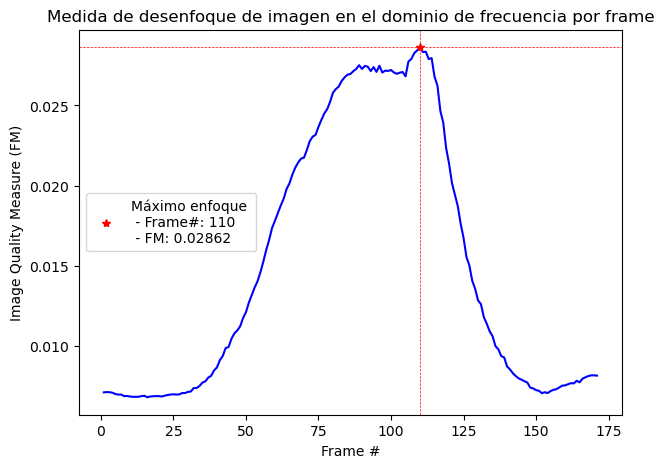

In [882]:
showGraph(list(range(1, len(video_fm) + 1)), video_fm, 
          'Medida de desenfoque de imagen en el dominio de frecuencia por frame', 
          'Frame #', 
          'Image Quality Measure (FM)')


### 2.1 Medición sobre una ROI ubicada en el centro del frame.

In [896]:
percent = [5, 10, 20, 50, 100] # Porcentajes del área total
video_fm = {z: [] for z in percent}

# Por cada frame del video:
for frame in video_frames:
    # Convertir a escala de grises
    frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Para los recortes establecidos
    for p in percent:
        # Obtener región de interés - dimensiones y posición
        roiShape, roiP = getDims(frame_g.shape, p, ['c', 'c'])
        frame_roi = getROI(frame_g, roiShape, roiP)

        # Calcular métrica y almacenar para gráfico
        video_fm[p].append(getFM(frame_roi))


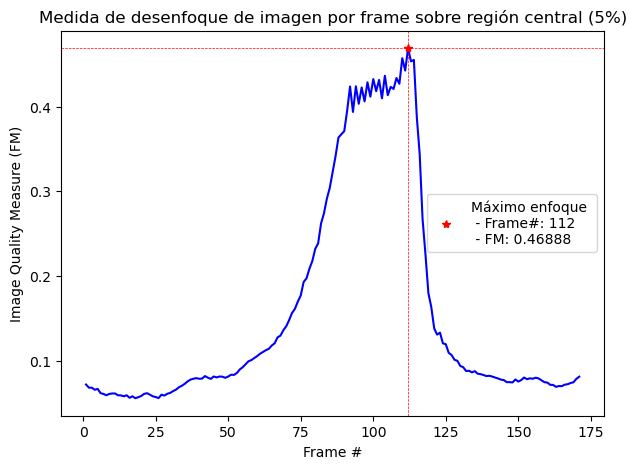

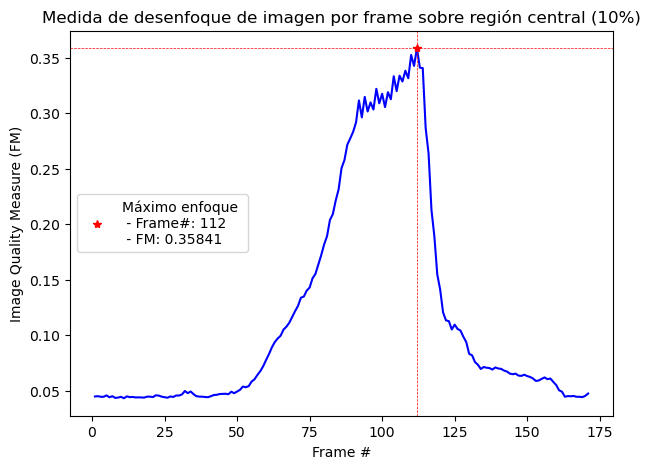

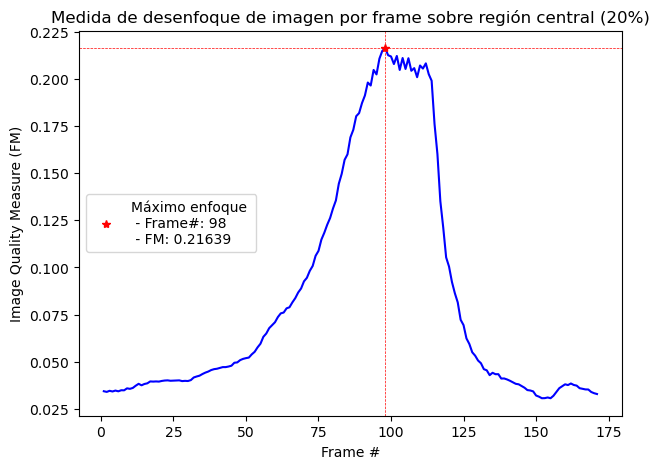

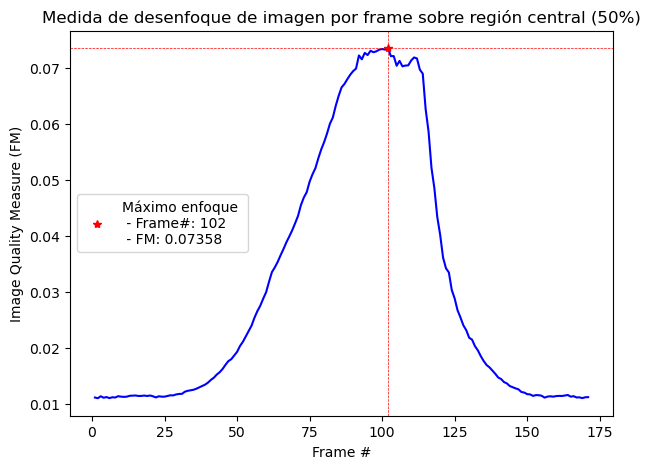

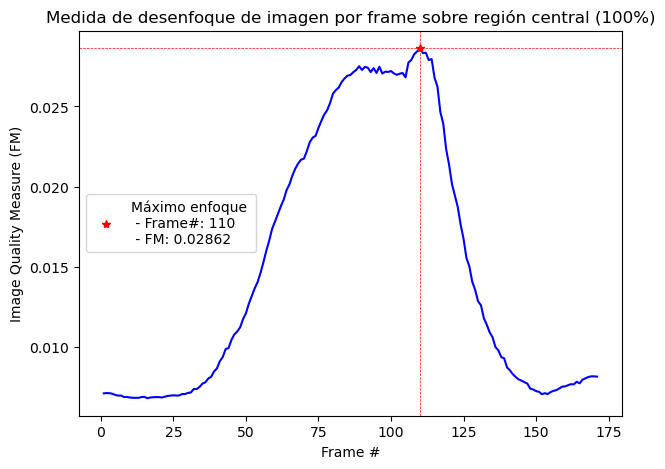

In [897]:
for p in percent:
    showGraph(list(range(1, len(video_fm[p]) + 1)), video_fm[p], 
          f'Medida de desenfoque de imagen por frame sobre región central ({p}%)', 
          'Frame #', 
          'Image Quality Measure (FM)')


## 2.

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: ["Analysis of focus measure operators in shapefrom focus"](./papers/AnalysisOfFocusMeasureOperators.pdf).
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

## Adicional

Aplicar unsharp masking para expandir la zona de enfoque y devolver.